/Users/sd3ntato/Desktop/Master Thesis/Master-thesis/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting experiment...
Start of experience:  0
Current Classes:  [0, 1]
number of samples: 12665
-- >> Start of training phase << --
100%|██████████| 99/99 [00:02<00:00, 42.76it/s]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


100%|██████████| 99/99 [00:05<00:00, 16.94it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5425
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9593
100%|██████████| 99/99 [00:05<00:00, 16.62it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.4642
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9972
-- >> End of training phase << --
Start of experience:  1
Current Classes:  [2, 3]
number of samples: 12089
-- >> Start of training phase << --
100%|██████████| 95/95 [00:07<00:00, 13.20it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7910
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6727
100%|██████████| 95/95 [00:07<00:00, 13.08it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5059
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9592
-- >> End of training phase << --
Start of experience:  2
Current Classes:  [4, 5]
number of samples: 11263
-- >> Start of training phase << --
100%|███████

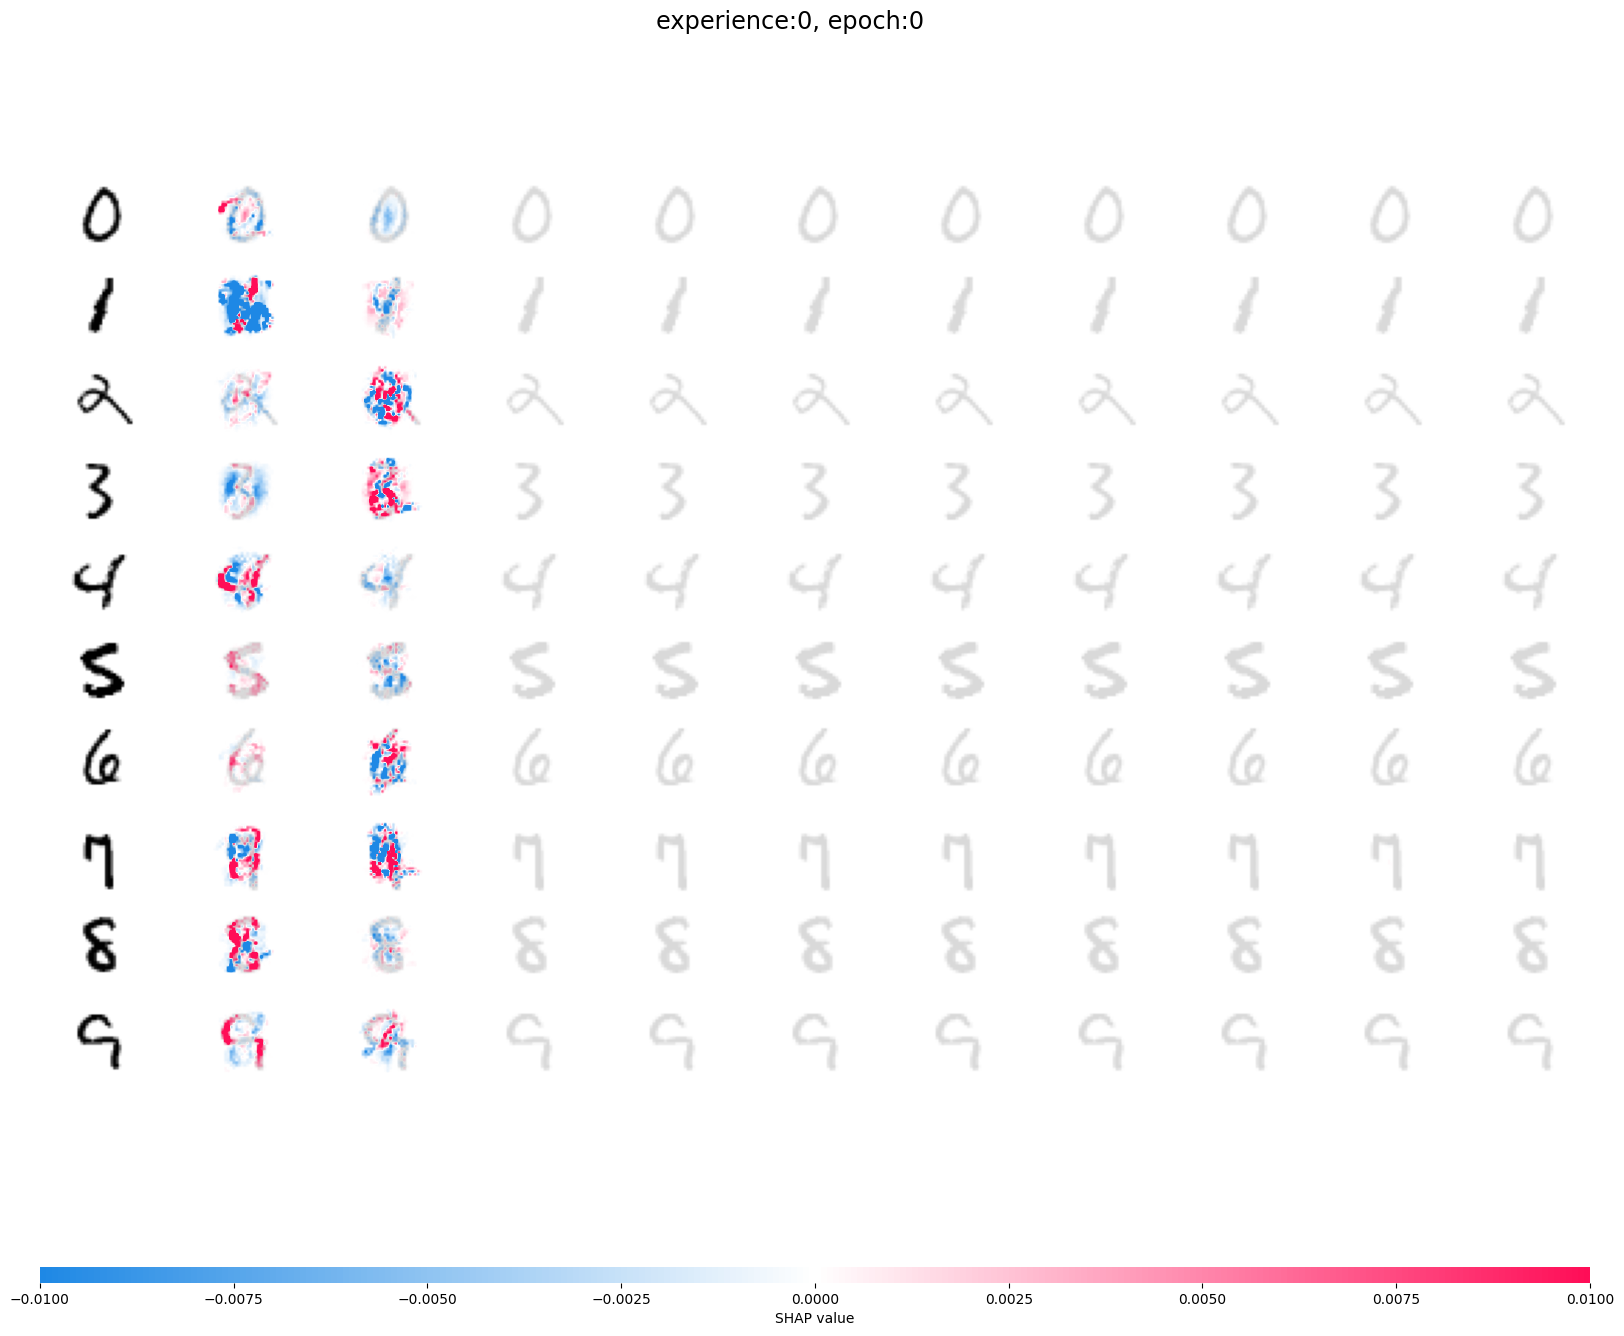

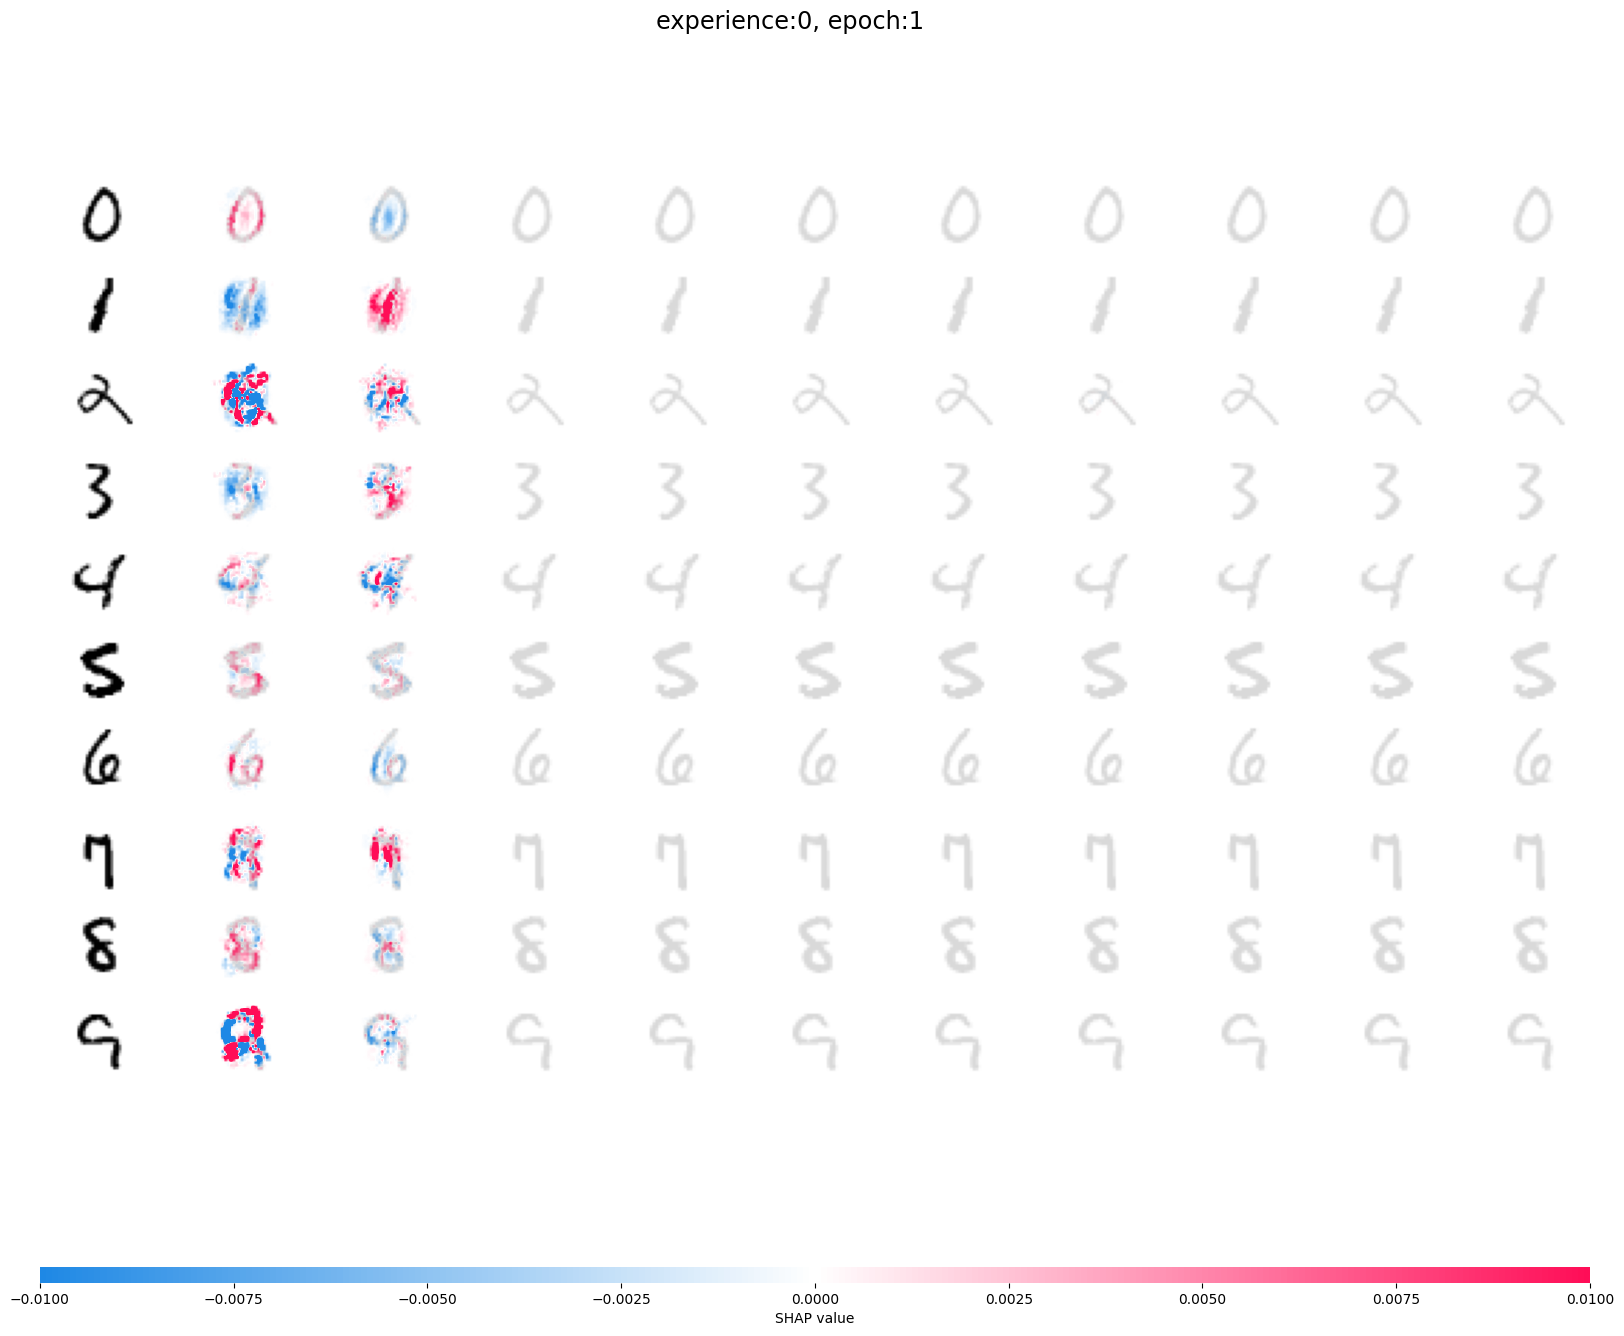

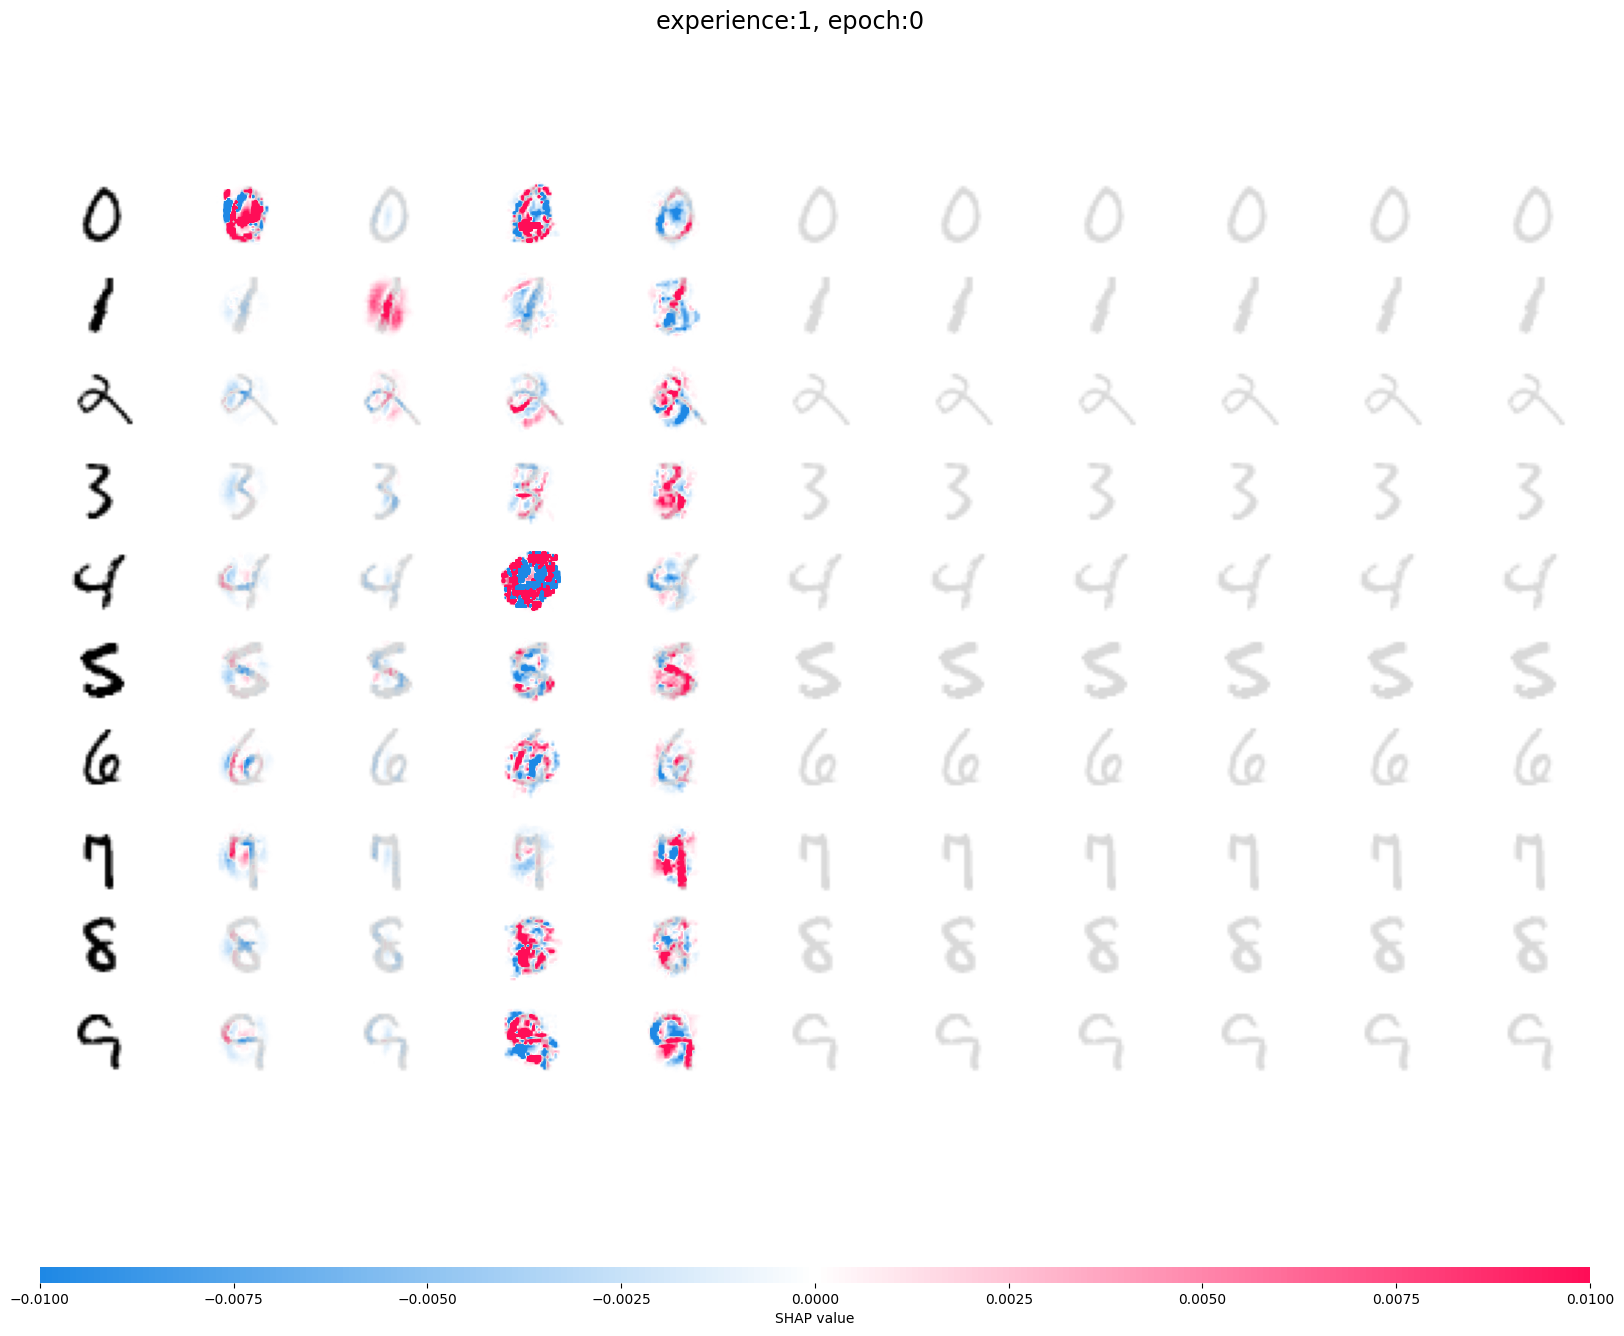

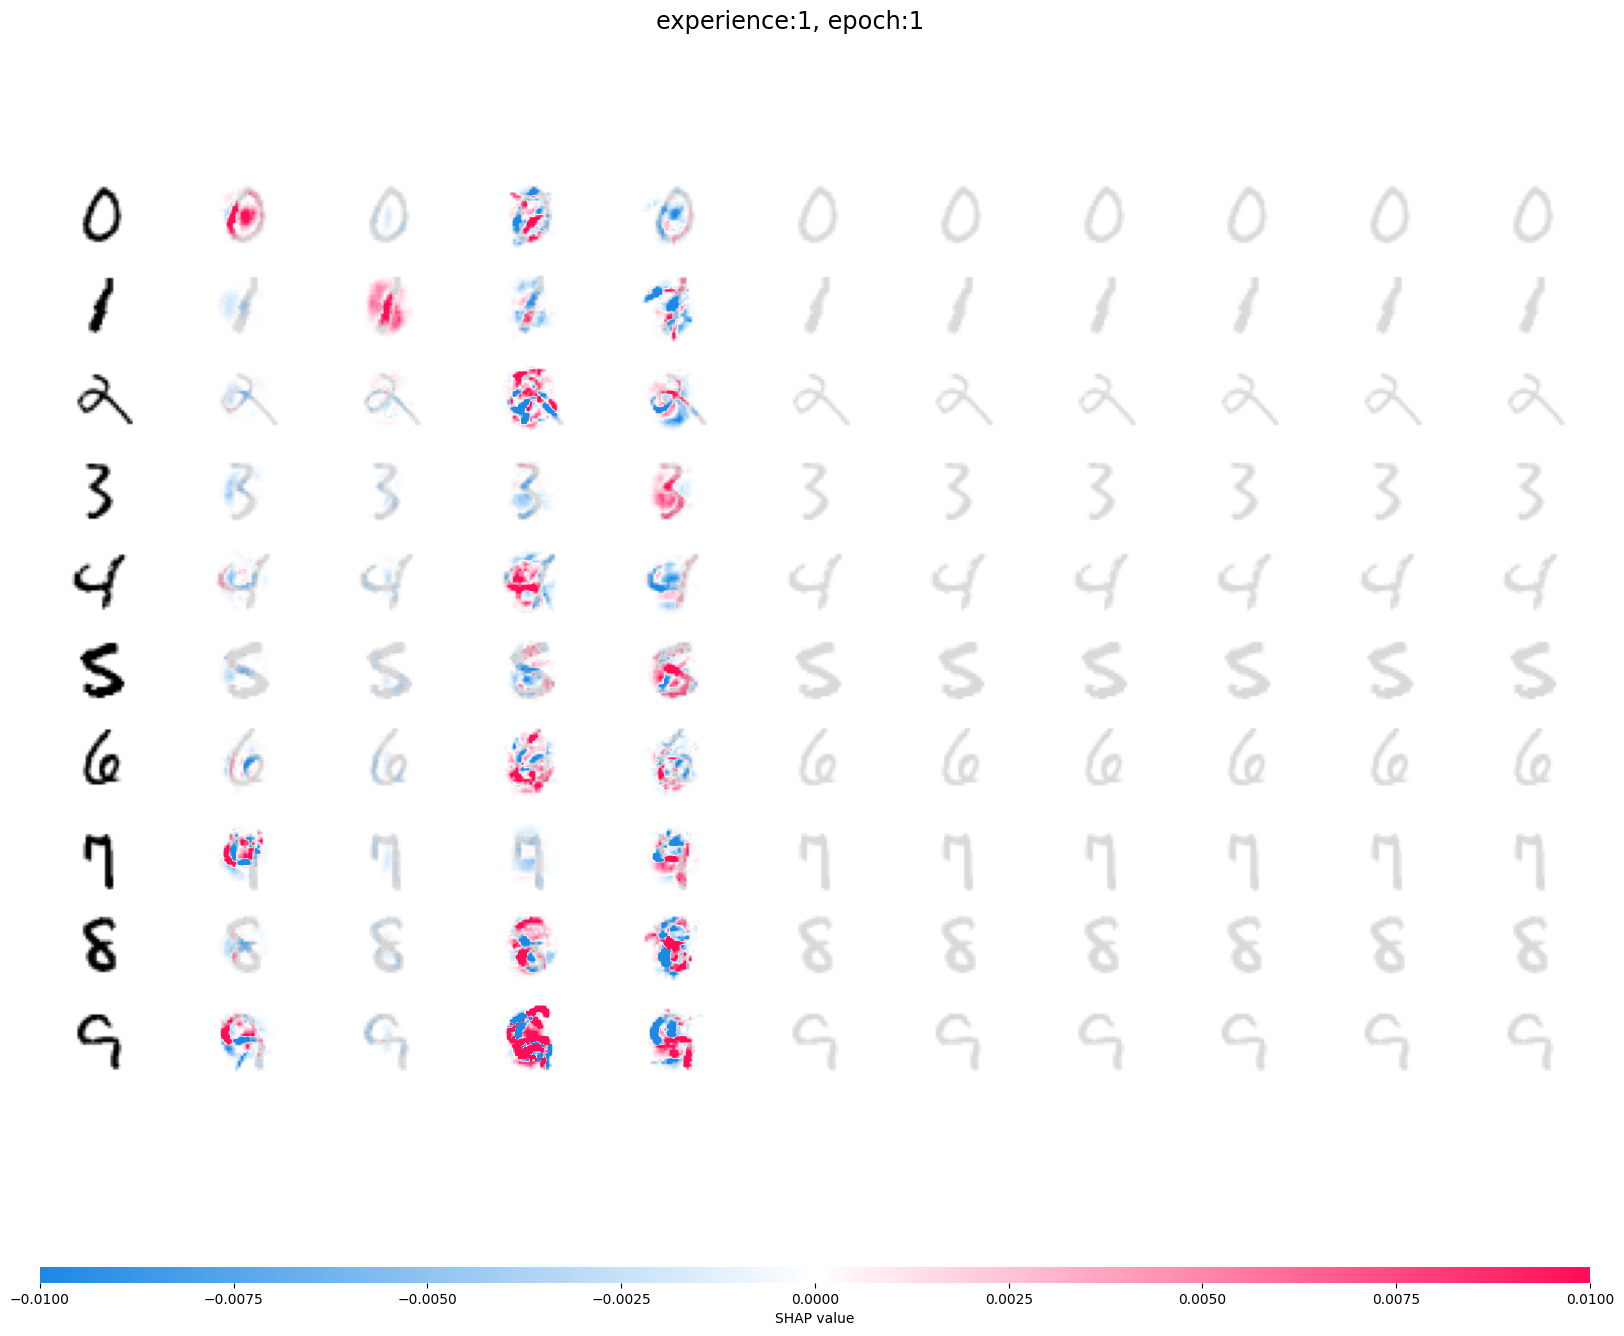

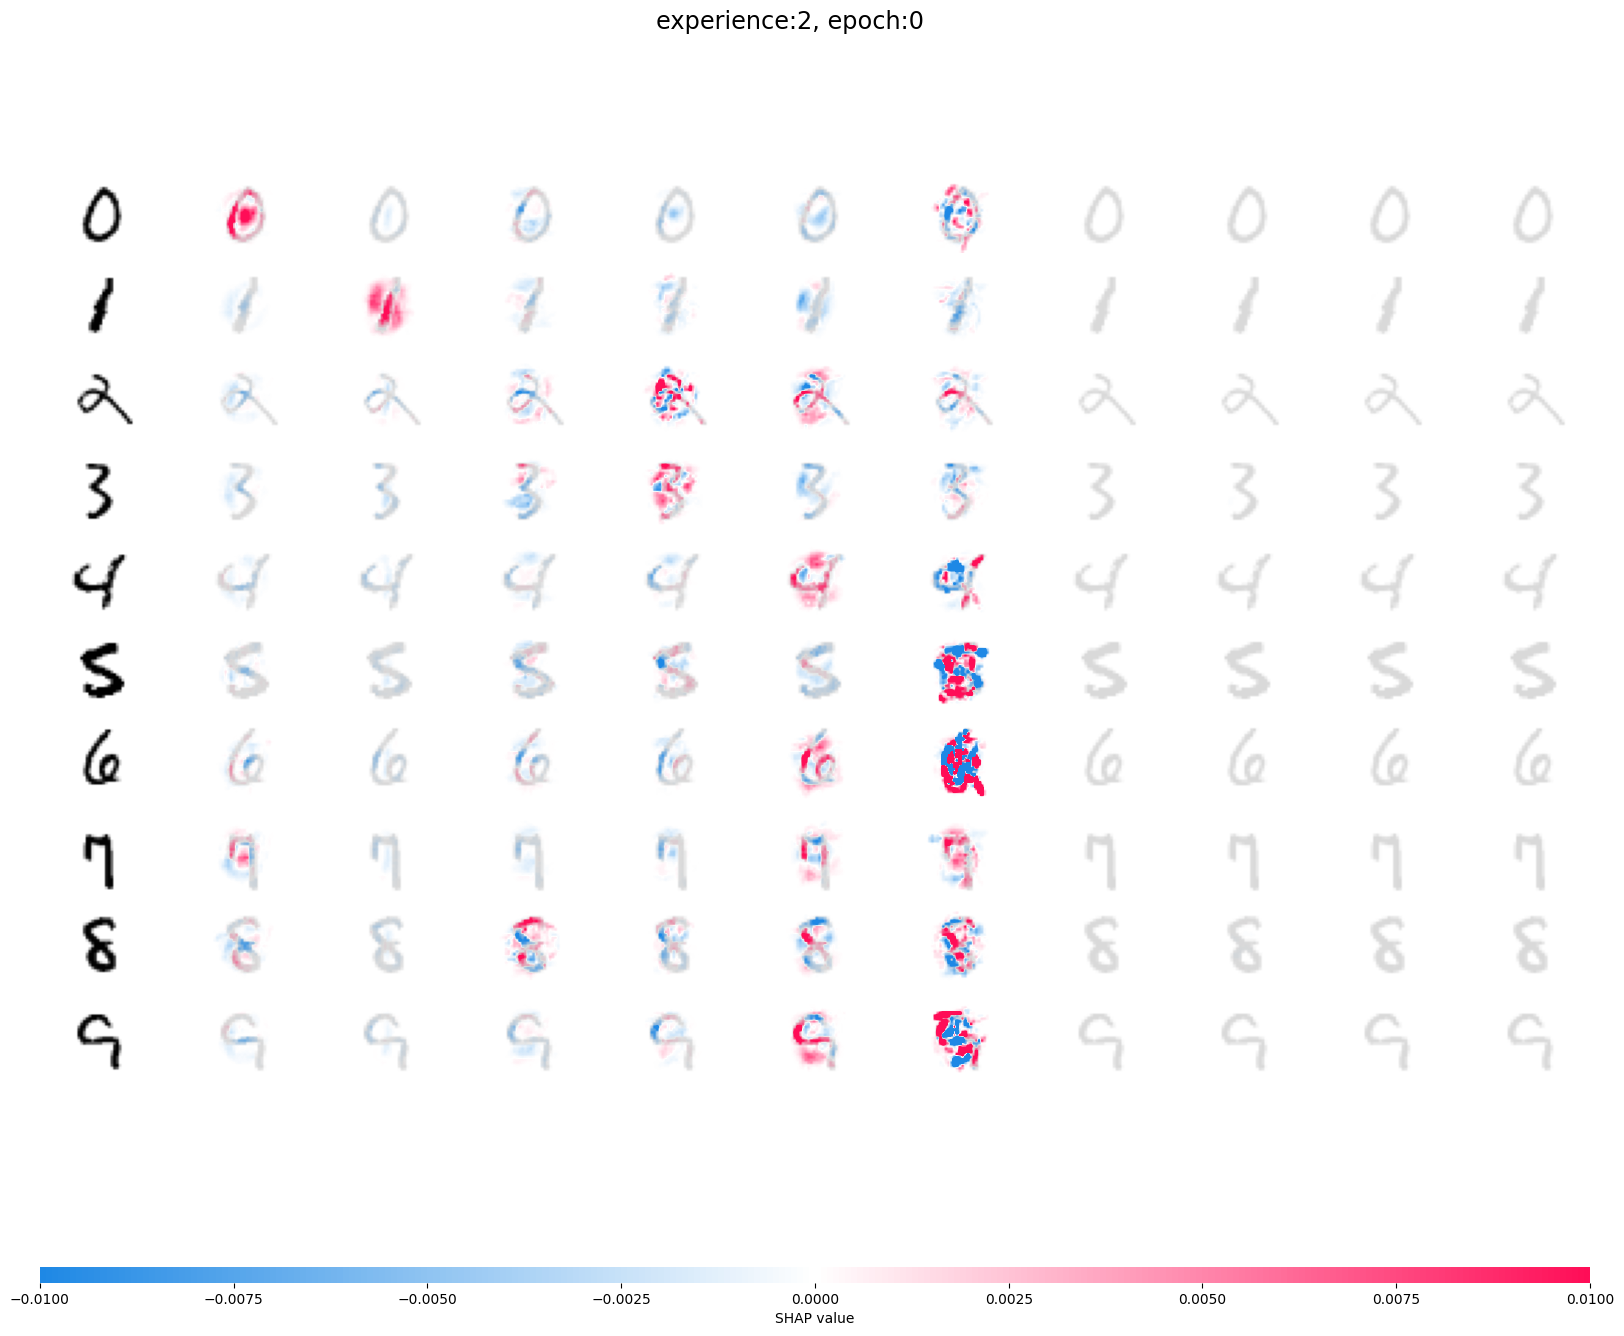

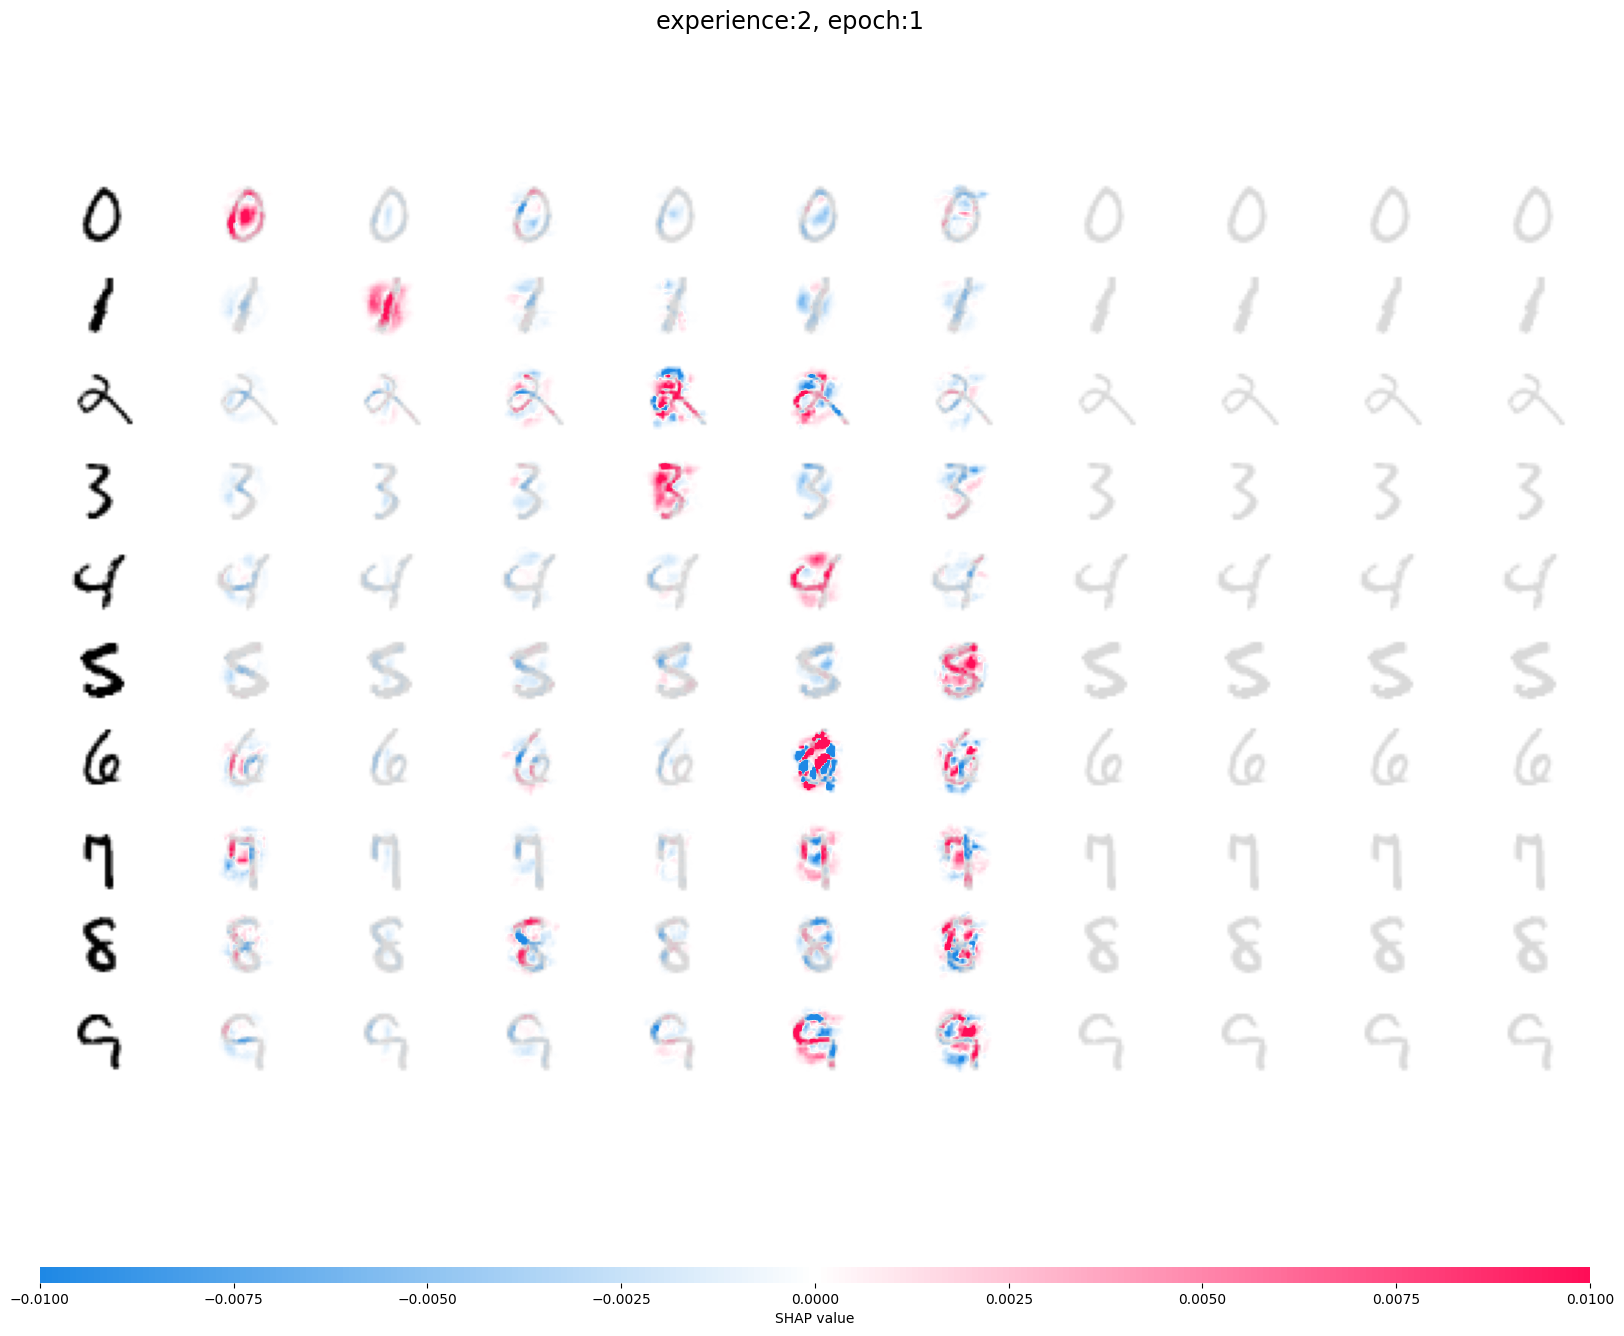

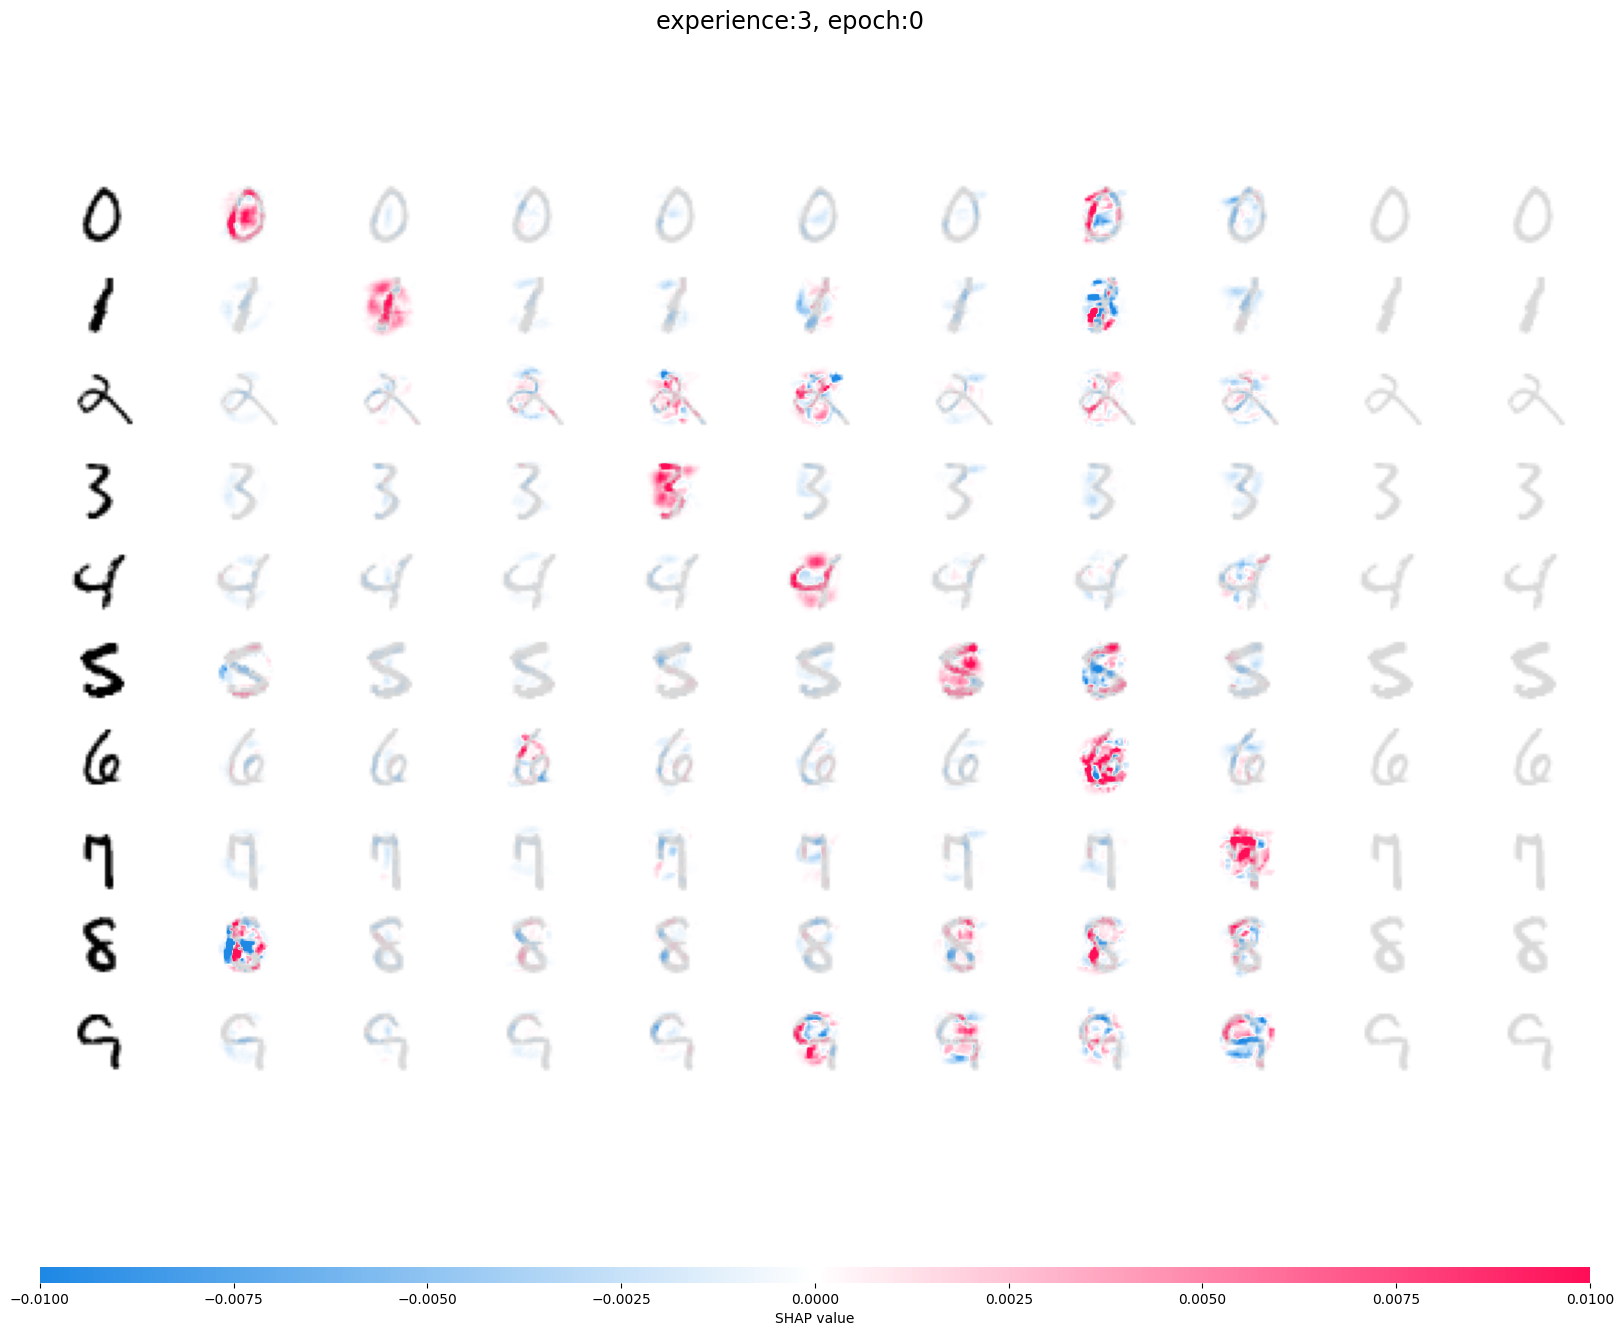

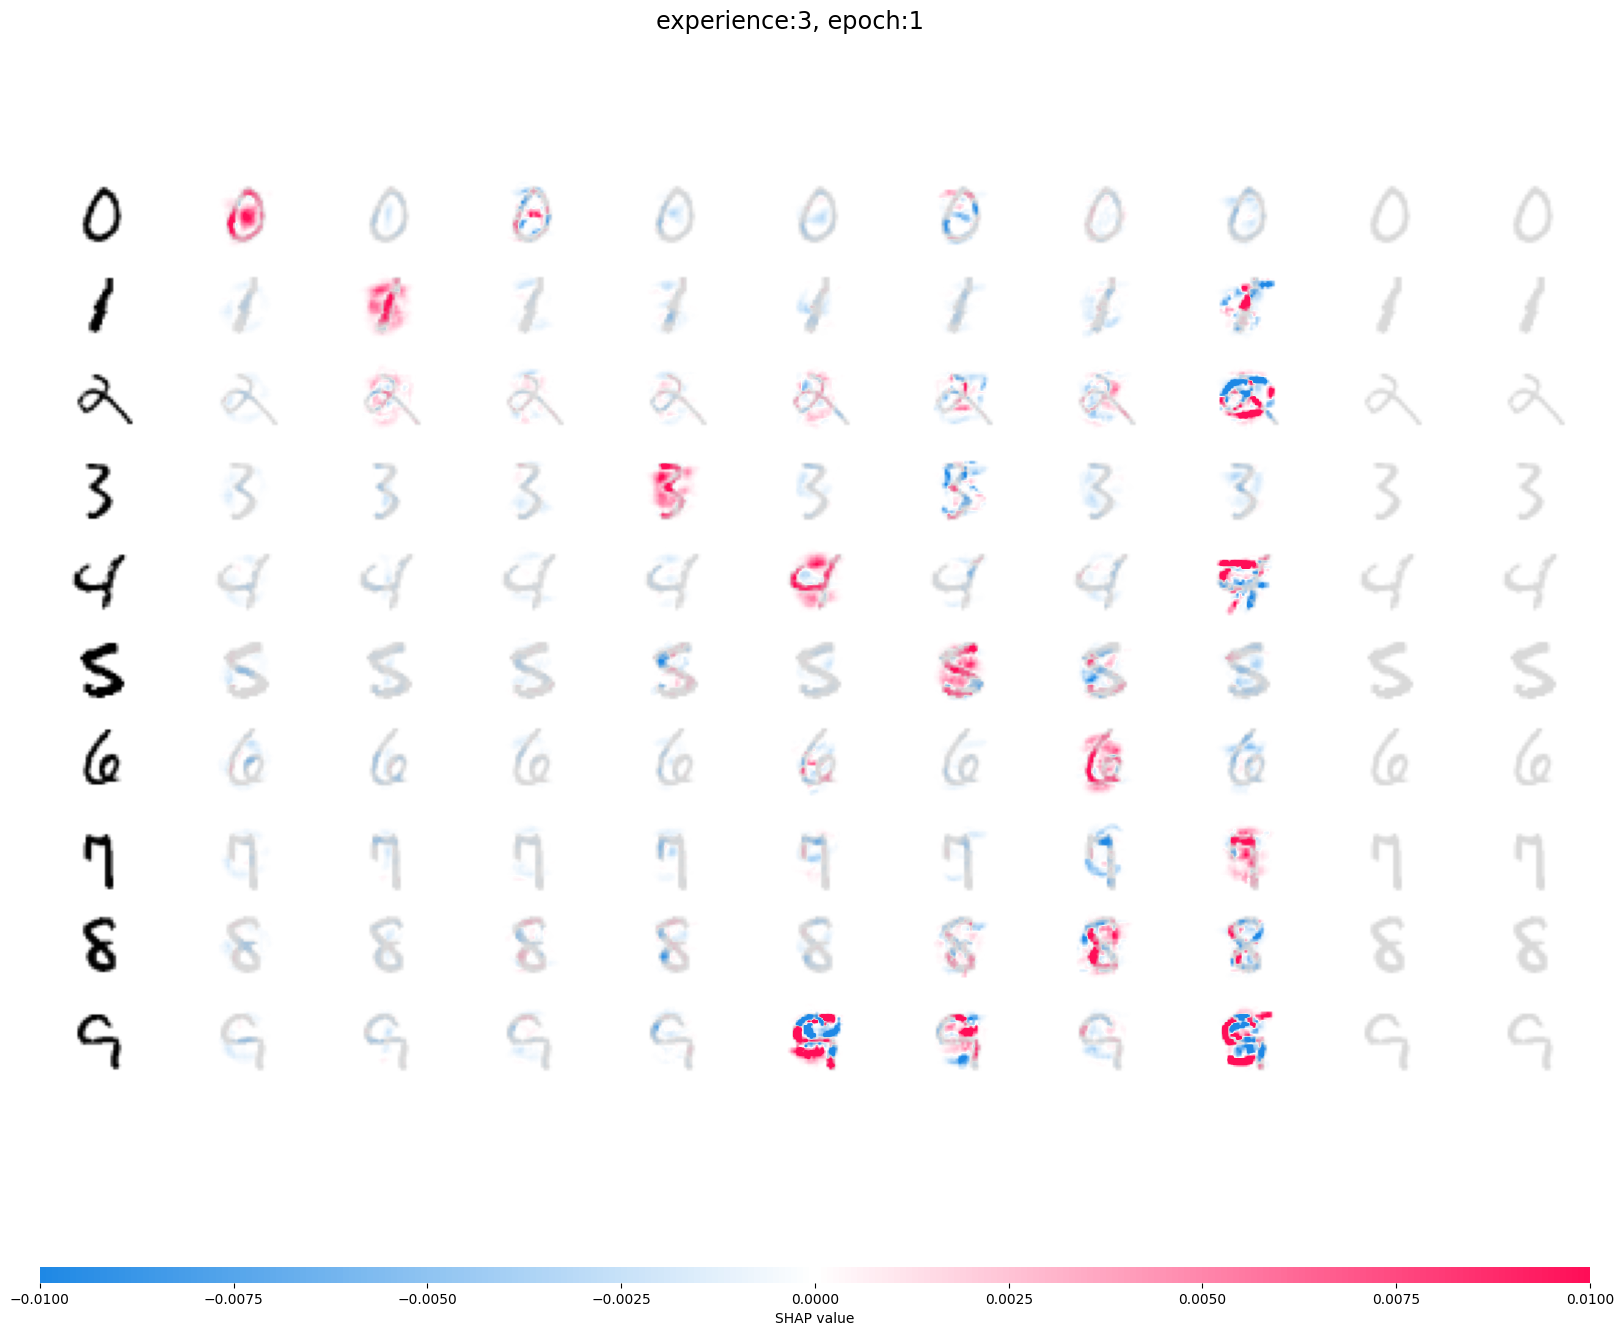

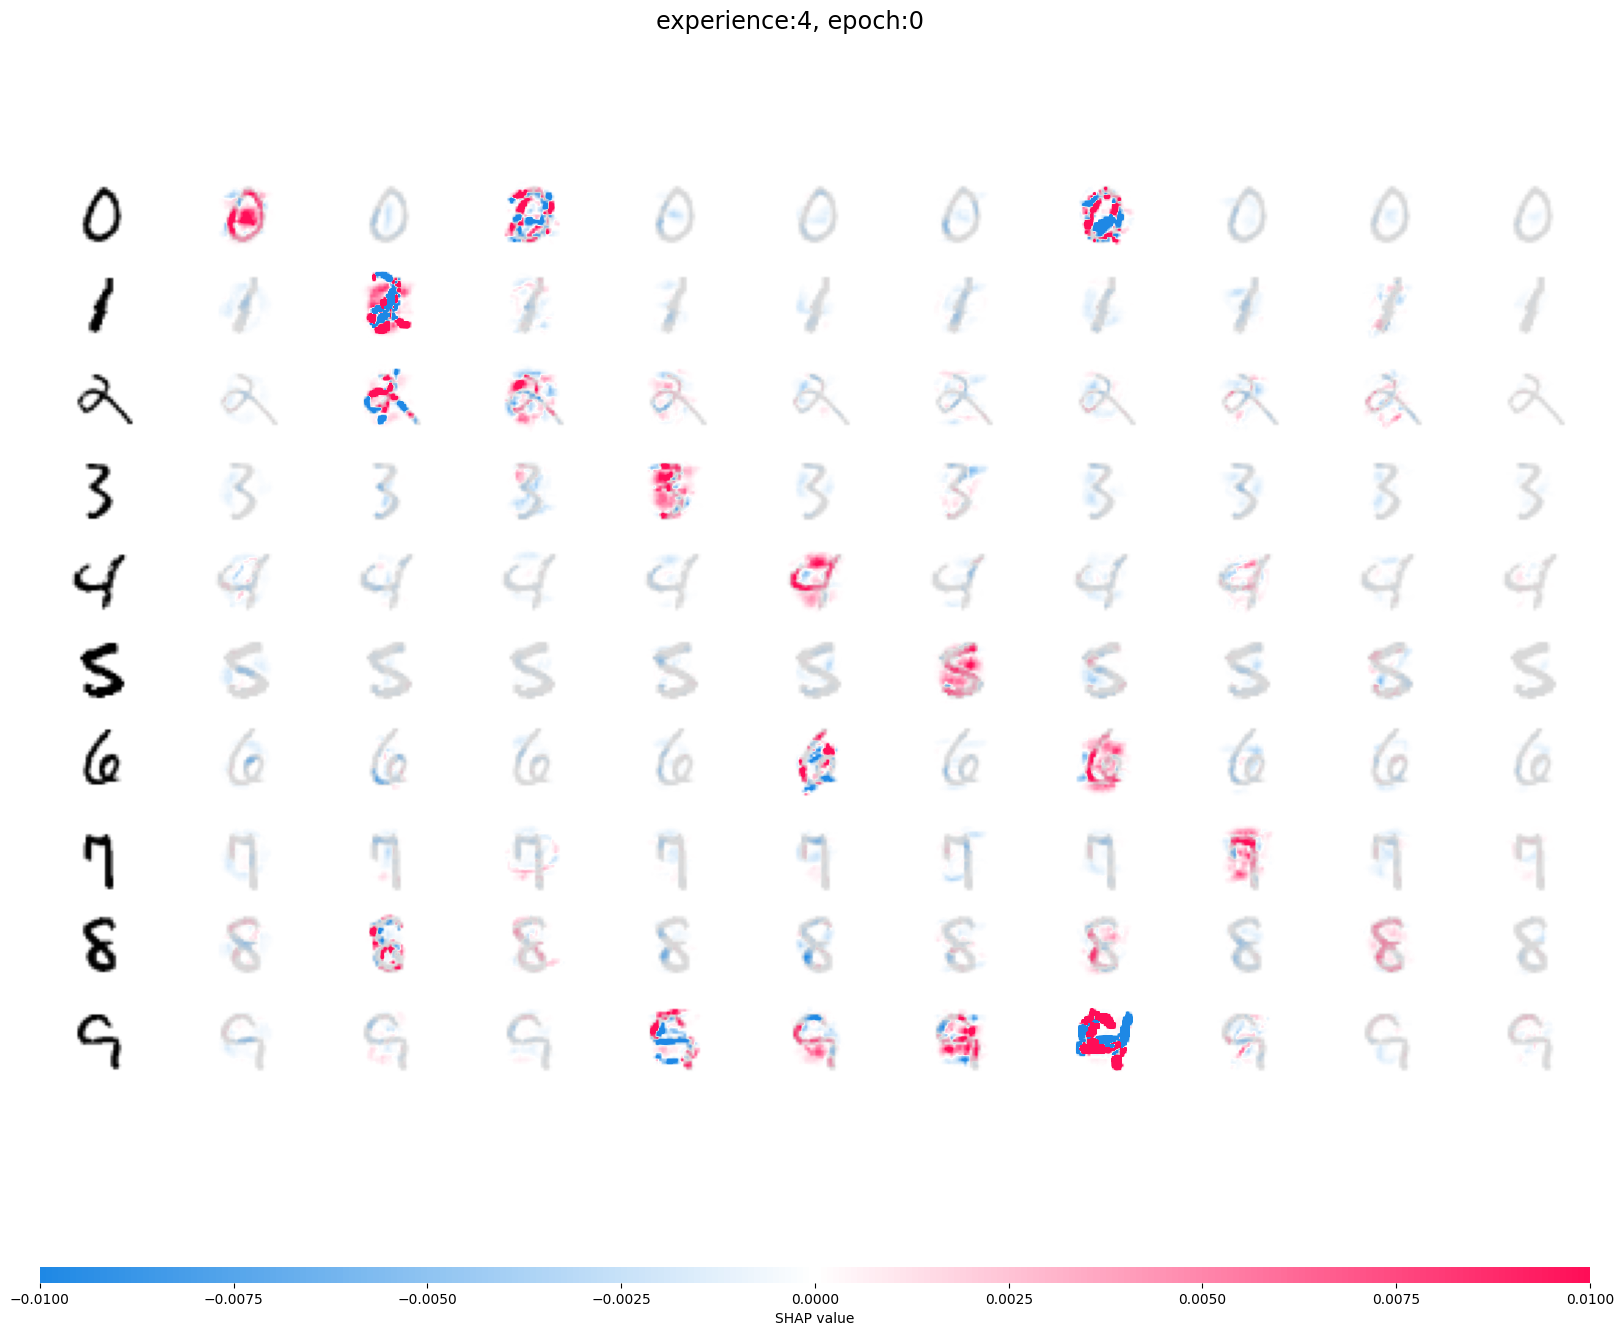

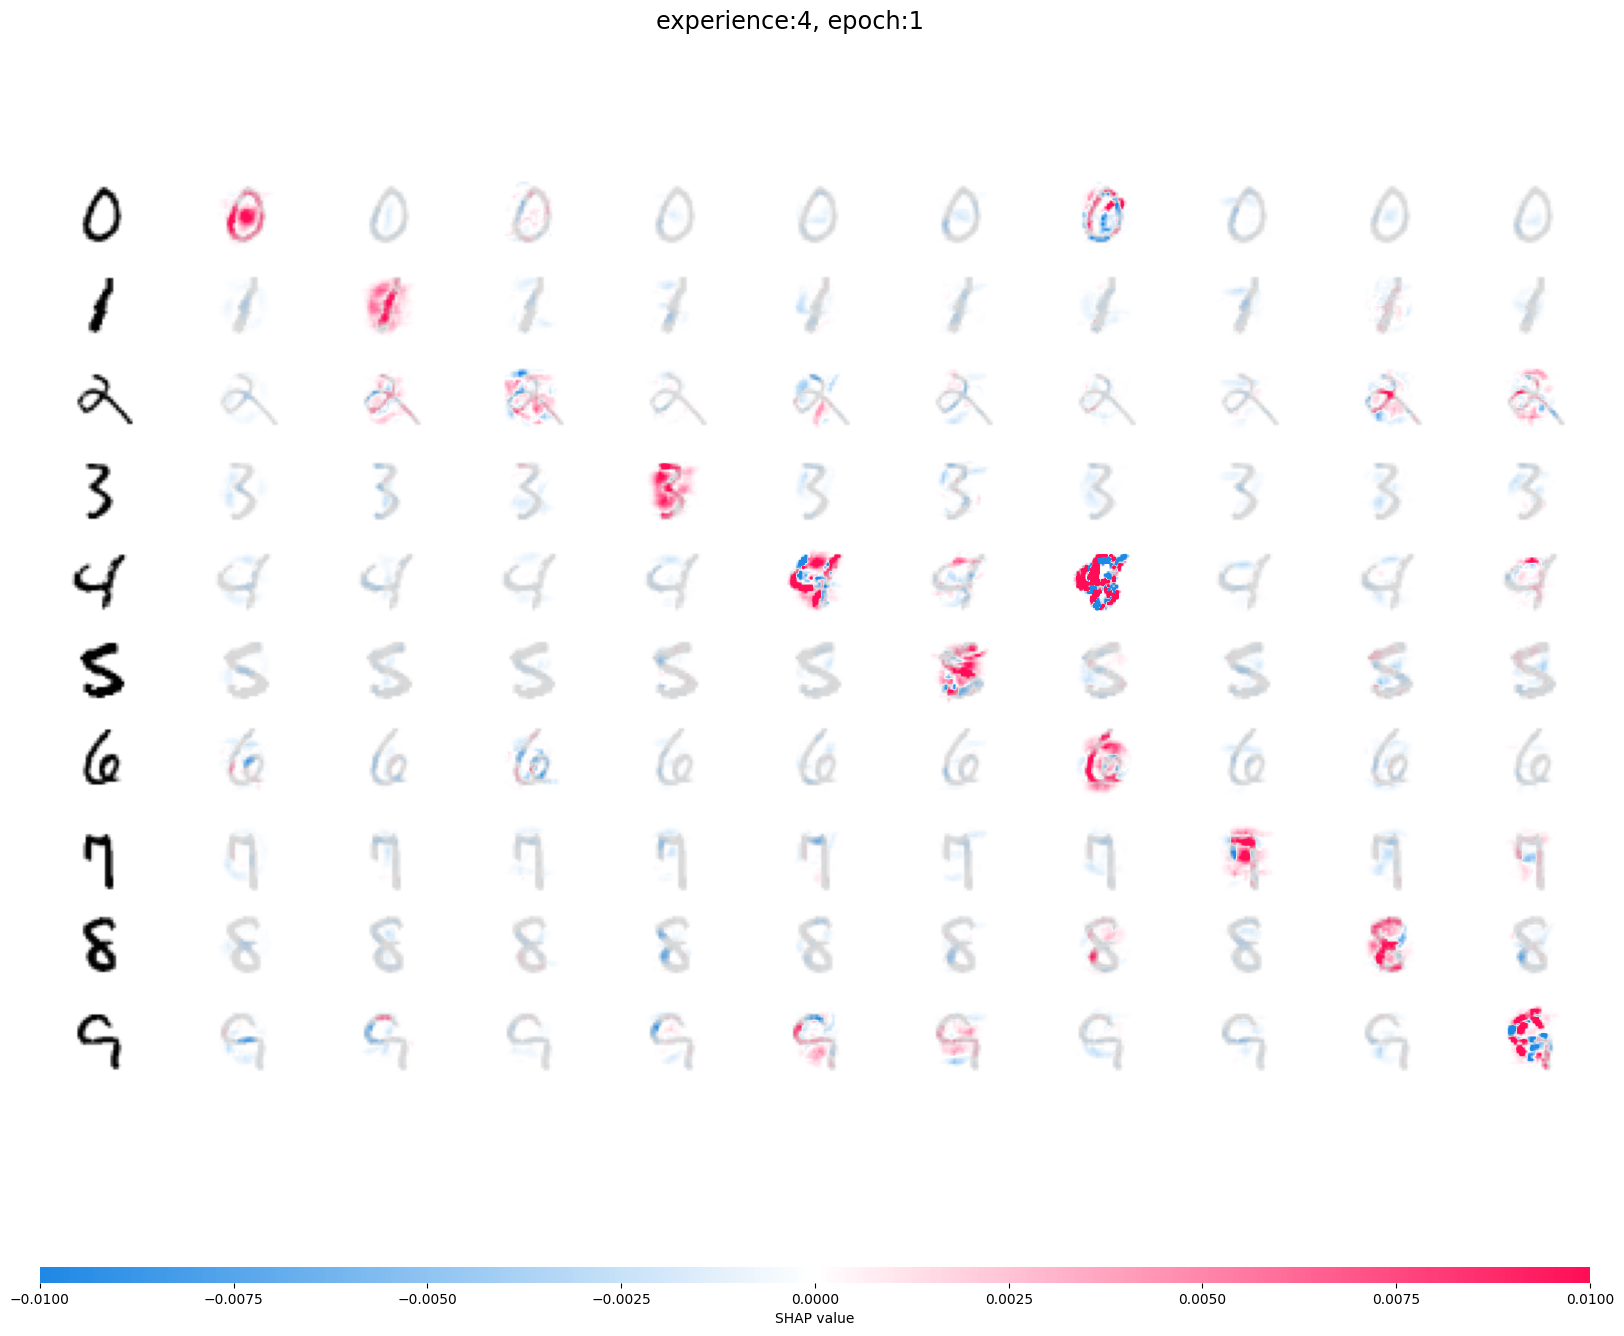

In [1]:
from avalanche.training.plugins import ReplayPlugin, EWCPlugin
from avalanche.training.templates import SupervisedTemplate
from avalanche.training.plugins import EvaluationPlugin
from utils import ShapMetric, prepare_shap_samples_MNIST
from avalanche.logging import InteractiveLogger
from my_model_definitions import Conv0
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
import torch

from avalanche.evaluation.metrics import (
    forgetting_metrics,
    accuracy_metrics,
    loss_metrics,
)

from experiments import exp0

# preparing images for shap.
background, test_images = prepare_shap_samples_MNIST()

gif_name = "Conv0_ewc_replay"

# MODEL DEFINITION
train_epochs = 2
lr = 0.001
model = Conv0()

# EVAL PLUGIN
interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    ShapMetric(
        model=model,
        n_epochs=train_epochs,
        background=background,
        test_images=test_images,
        gif_name=gif_name,
    ),
    loggers=[interactive_logger],
)

# STRATEGY DEFINITION
replay = ReplayPlugin(mem_size=100)
ewc = EWCPlugin(ewc_lambda=0.001)
strategy = SupervisedTemplate(
    model,
    torch.optim.Adam(model.parameters(), lr=lr),
    CrossEntropyLoss(),
    plugins=[replay, ewc],
    train_mb_size=128,
    train_epochs=train_epochs,
    eval_mb_size=100,
    evaluator=eval_plugin,
)

exp0(n_experiences=5, strategy=strategy, gif_name=gif_name)
